In [67]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [68]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive
logits_path = os.path.join(cwk_dir, "demo", "solution_C_predicted_logits.csv") #Path to evaluation logits
dataset_path = os.path.join(cwk_dir, "data/training_data/training_data/NLI/dev.csv") #Path to the dataset used for evaluation

# Evaluation Setup

In [69]:
import sys
from keras.utils import to_categorical

In [70]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import typing
import keras

@dataclass(frozen=True)
class GeneralKeys:
    """
    Dataclass for general keys for the process
    """

    PREMISE_KEY: str = "Premise"
    HYPOTHESIS_KEY: str = "Hypothesis"
    LABEL_KEY: str = "Label"
    LOSS_KEY: str = "Loss"
    PREDICTED_KEY: str = "Predicted Label"
    TRUE_KEY: str = "True Label"


@dataclass
class MacroMetric:
    """
    Dataclass for metrics that can be turned into macro & weighted macro
    """

    NORMAL_KEY: str
    MACRO_KEY: str
    WEIGHTED_KEY: str

    def __init__(self, key: str):
        self.NORMAL_KEY: str = key
        self.MACRO_KEY: str = f"Macro {key}"
        self.WEIGHTED_KEY: str = f"Weighted Macro {key}"


@dataclass(frozen=True)
class MetricKeys:
    """
    Dataclass associated with keys for the evaluation metrics
    """

    ACCURACY_KEY: str = "Accuracy"
    PRECISION: MacroMetric = MacroMetric(key="Precision")
    F1: MacroMetric = MacroMetric(key="F1-Score")
    RECALL: MacroMetric = MacroMetric(key="Recall")
    MCC_KEY: str = "MCC"
    LOSS_KEY: str = "Loss"


def evaluate(true_labels: np.array, predicted_logits: np.array) -> pd.DataFrame:
    """
    Uses the true and predicted labels & sklearn to create extensive evaluation metrics. Formats into a dataframe that it returns

    true_labels:        (N) sized array storing the true (0, 1) labels of the data
    predicted_logits:   (N, 2) sized array storing the predicted logits from the model, therefore the predicted probabilities for either class
    """
    loss = log_loss(true_labels, predicted_logits)  # Uses logits for loss

    # Otherwise utilises argmax of the prediction logits, to get the predicted labels
    predicted_labels = np.argmax(predicted_logits, axis=1)

    accuracy = accuracy_score(true_labels, predicted_labels)

    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predicted_labels
    )

    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    macro_precision = precision_score(true_labels, predicted_labels, average="macro")
    macro_recall = recall_score(true_labels, predicted_labels, average="macro")
    macro_f1 = f1_score(true_labels, predicted_labels, average="macro")

    mcc = matthews_corrcoef(true_labels, predicted_labels)

    # Format into dataframe for easier viewing
    df = pd.DataFrame(
        [
            [
                accuracy,
                precision,
                macro_precision,
                weighted_precision,
                recall,
                macro_recall,
                weighted_recall,
                f1,
                macro_f1,
                weighted_f1,
                mcc,
                loss,
            ]
        ],
        columns=[
            MetricKeys.ACCURACY_KEY,
            MetricKeys.PRECISION.NORMAL_KEY,
            MetricKeys.PRECISION.MACRO_KEY,
            MetricKeys.PRECISION.WEIGHTED_KEY,
            MetricKeys.RECALL.NORMAL_KEY,
            MetricKeys.RECALL.MACRO_KEY,
            MetricKeys.RECALL.WEIGHTED_KEY,
            MetricKeys.F1.NORMAL_KEY,
            MetricKeys.F1.MACRO_KEY,
            MetricKeys.F1.WEIGHTED_KEY,
            MetricKeys.MCC_KEY,
            MetricKeys.LOSS_KEY,
        ],
    )
    return df


@dataclass
class ClassLabels:
    """
    Dataclass for the string class labels. Used in the confusion matrix generation
    """

    ZERO_KEY: str = "Not Entailing"
    ONE_KEY: str = "Entailing"


def draw_confusion_matrix(
    true_labels: np.array,
    predicted_logits: np.array,
    classes: typing.List[str] = [ClassLabels.ZERO_KEY, ClassLabels.ONE_KEY],
) -> np.array:
    """
    Will make a confusion matrix using the predicted and true values & will display this. Returns the confusion matrix as an array
    """
    predicted_labels = np.argmax(predicted_logits, axis=1)

    conf_mat = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp.plot()
    plt.show()
    return conf_mat


def most_confused_samples(
    true_logits: np.array,
    predicted_logits: np.array,
    premises: typing.List[str],
    hypotheses: typing.List[str],
    num: int = 5,
    loss_function: callable = keras.losses.categorical_crossentropy,
) -> pd.DataFrame:
    """
    Will print the num samples with the highest loss

    true_logits:        (N, 2) sized array storing the one hot encoded labels of the data
    predicted_logits:   (N, 2) sized array storing the predicted logits from the model, therefore the predicted probabilities for either class
    premises:           (N) sized array storing the string premises
    hypotheses:         (N) sized array storing the string hypotheses

    num:                Integer number of samples to report about. The top M (or num) samples will be displayed
    loss_function:      Executable function used for the loss calculation. By default this is just categorical cross entropy
    """
    # Gets the samples that have the highest loss
    loss_per_sample = [
        loss.numpy() for loss in loss_function(true_logits, predicted_logits)
    ]
    largest_indices = np.argsort(loss_per_sample)[-num:][::-1]

    predicted_labels = np.argmax(predicted_logits, axis=1)
    true_labels = np.argmax(true_logits, axis=1)

    # Makes the dataframe with the confused samples
    confused_samples = [
        [
            premises[i],
            hypotheses[i],
            loss_per_sample[i],
            predicted_labels[i],
            true_labels[i],
        ]
        for i in largest_indices
    ]
    df = pd.DataFrame(
        confused_samples,
        columns=[
            GeneralKeys.PREMISE_KEY,
            GeneralKeys.HYPOTHESIS_KEY,
            GeneralKeys.LOSS_KEY,
            GeneralKeys.PREDICTED_KEY,
            GeneralKeys.TRUE_KEY,
        ],
    )
    return df

In [71]:
import typing
from dataclasses import dataclass
import pandas as pd
import os
from dataclasses import dataclass
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk
import numpy as np

@dataclass(frozen=True)
class DatasetKeys:
    """
    Dataclass associated with keys for the data csvs
    """

    PREMISE_KEY: str = GeneralKeys.PREMISE_KEY.lower()
    HYPOTHESIS_KEY: str = GeneralKeys.HYPOTHESIS_KEY.lower()
    LABEL_KEY: str = GeneralKeys.LABEL_KEY.lower()

def load_data_csv(
    filepath: str,
) -> typing.Tuple[typing.List[str], typing.List[str], typing.List[int]]:
    """
    Will load in data from the csv filepath specified. Expects the string filepath to a csv file. Returns tuple of the premises, hypotheses and labels
    """
    dataset = pd.read_csv(filepath)
    premises = dataset[DatasetKeys.PREMISE_KEY].astype(str).tolist()
    hypotheses = dataset[DatasetKeys.HYPOTHESIS_KEY].astype(str).tolist()
    labels = dataset[DatasetKeys.LABEL_KEY].astype(str).tolist()
    return (premises, hypotheses, labels)

# Load in Predictions

In [72]:
premises, hypotheses, true = load_data_csv(filepath=dataset_path)
true = np.array([int(x) for x in true])

In [73]:
predictions0 = pd.read_csv(logits_path)["0"].astype(float).tolist()
predictions1 = pd.read_csv(logits_path)["1"].astype(float).tolist()
predictions = np.column_stack((np.array(predictions0), np.array(predictions1)))
predictions

array([[-2.542238 ,  2.042342 ],
       [ 2.397689 , -2.3444493],
       [ 0.6640359, -0.5782072],
       ...,
       [-3.1676753,  3.0055118],
       [ 2.819711 , -2.7764752],
       [-2.4594204,  2.1997325]])

# Evaluation

In [74]:
#Evaluation Metrics
test_metrics = evaluate(true_labels=true, predicted_logits=np.array(predictions))
test_metrics.to_csv("solution_B_metrics.csv", index=False)
test_metrics

,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.879917,0.879875,0.879919,0.879917,0.888729,0.879621,0.879917,0.88428,0.879746,0.879893,0.759539,4.039945


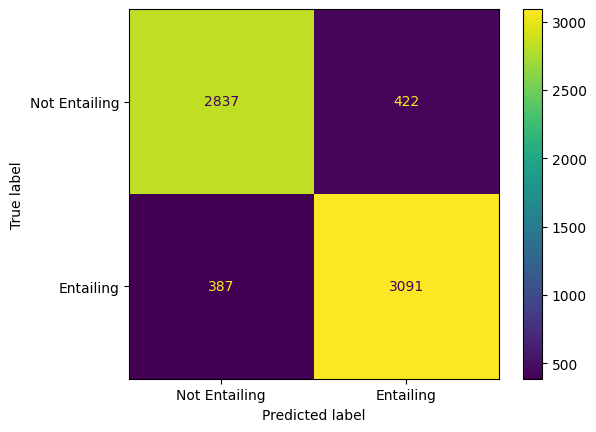

In [75]:
#Confusion matrix
conf_mat = draw_confusion_matrix(true_labels=true, predicted_logits=np.array(predictions))

In [76]:
#Show the most confused samples
df = most_confused_samples(true_logits=to_categorical(true), predicted_logits=np.array(predictions), premises=premises, hypotheses=hypotheses, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,She failed to finish.,She competed in the women's event at the 2015 ...,16.118096,1,1
1,Two dancers in azure appear to be performing i...,A pair of people are in the alleyway.,16.118096,1,1
2,"You can enter Temple Bar from Dame Street, or ...",The only way to get to Temple Bar Square is vi...,16.118096,0,1
3,and they come to this country and uh commit a ...,They should be given only one strike on seriou...,16.118096,0,1
4,Another article admits that Tipper Gore is a p...,Tipper Gore has a reputation for being an asse...,16.118096,1,1
5,but uh he knows when he's overspends and when ...,"When he goes over budget, he uses his credit ...",16.118096,1,1
6,The Kal's performance in the fight seemed to c...,Adrin thought the Kal's were much tougher afte...,16.118096,1,1
7,It was released as the album 's second single ...,"It is the second track from their 1987 album ""...",16.118096,1,1
8,Adapting the research case study to the evalua...,The research doesn't need to be adapted,16.118096,0,0
9,Here's the 439 feet + (59 feet x 0.6) = 474 f...,This math equation might be correct.,16.118096,1,1
